In [1]:
import os
import site
import sqlite3
import sys

import logzero
import numpy as np
import pandas as pd
import yaml
from logzero import logger
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from tqdm import tqdm
from tqdm.notebook import tqdm
from yaml import dump, load, safe_load

In [2]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [3]:
plt.rcParams["figure.figsize"] = 15, 15
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["axes.labelpad"] = 10
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01

In [4]:
pd.set_option("expand_frame_repr", True)
pd.set_option("colheader_justify", "right")
pd.set_option("precision", 4)

pd.set_option("max_rows", 100)
pd.set_option("display.width", 200)
pd.set_option("max_columns", 100)
pd.set_option("max_colwidth", 50)
pd.set_option("column_space", 50)

In [5]:
log_path = "logs/"
log_file = "ts_decomposition.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [6]:
sys.path.append("../../sql")
import queries

# sys.path.append("../source")
# import ts_tools

In [10]:
configs = None
try:
    with open("../configs/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_paths"]["db_path"]

city = configs["location_info"]["city"]
state = configs["location_info"]["state"]
db_file = city + "_" + state + ".db"

db_table1 = configs["table_names"]["db_table1"]
db_table2 = configs["table_names"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [11]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()

# get_nsr_rows = queries.select_nsr_rows
# year1 = "2020"
# year2 = "2015"
# zipcode = "74145"

In [12]:
cursor.execute(queries.select_distinct_zips)
distinct_zipcodes = cursor.fetchall()
distinct_zipcodes = [z[0] for z in distinct_zipcodes]
logger.info(f"distinct zip codes:\n{distinct_zipcodes}")
print(distinct_zipcodes)

['10514', '12309', '14031', '14534', '14817', '32312', '32317', '32424', '32605', '32606', '32653', '32803', '32828', '32927', '53005', '53092', '53217', '53597', '53719', '75022', '75035', '76904', '77059', '77062', '78002', '78039', '78504', '78733', '85045', '85253', '85286', '85747', '86032', '90272', '91011', '94024', '94127', '95973', '98029', '98177', '98607', '99337', '99338']


In [13]:
zipcode_index = 0
params = {"zipcode": distinct_zipcodes[zipcode_index]}

select_nsr_rows = f"""
SELECT date_time,
-- year,
-- month, day, 
-- zipcode,
-- Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature,
Relative_Humidity,
Precipitable_Water,
-- Wind_Direction,
Wind_Speed
from nsrdb
where zipcode = :zipcode
-- and not (month = 2 and day = 29)
;
"""

df = pd.read_sql(
    select_nsr_rows,
    conn,
    params=params,
    index_col="date_time",
    parse_dates=["date_time"],
)

df.sort_index(axis=0, inplace=True)
df

,Clearsky_DNI,DNI,Clearsky_GHI,GHI,Temperature,Relative_Humidity,Precipitable_Water,Wind_Speed
date_time,,,,,,,,
1998-01-01 00:30:00,0.0,0.0,0.0,0.0,-12.0,72.10,0.206,2.5
1998-01-01 01:30:00,0.0,0.0,0.0,0.0,-12.0,76.05,0.201,2.5
1998-01-01 02:30:00,0.0,0.0,0.0,0.0,-13.0,73.98,0.195,2.4
1998-01-01 03:30:00,0.0,0.0,0.0,0.0,-13.0,78.30,0.192,2.3
1998-01-01 04:30:00,0.0,0.0,0.0,0.0,-14.0,76.43,0.193,2.2
...,...,...,...,...,...,...,...,...
2020-12-31 19:30:00,0.0,0.0,0.0,0.0,2.1,99.66,1.100,1.3
2020-12-31 20:30:00,0.0,0.0,0.0,0.0,2.2,100.00,1.000,1.5
2020-12-31 21:30:00,0.0,0.0,0.0,0.0,1.9,100.00,0.900,1.8


In [14]:
df_rsm = df.resample("M").mean().reset_index(drop=False)
df_rsm.set_index("date_time", inplace=True)
# df_rsm

,Clearsky_DNI,DNI,Clearsky_GHI,GHI,Temperature,Relative_Humidity,Precipitable_Water,Wind_Speed
date_time,,,,,,,,
1998-01-31,234.4731,119.3427,115.1774,75.3266,0.7715,87.3705,1.3012,1.9608
1998-02-28,296.5789,167.9107,163.8661,113.4866,0.7277,85.7623,1.0886,2.2045
1998-03-31,308.4435,168.6290,225.8454,152.4651,3.3669,85.9647,1.2524,1.9882
1998-04-30,358.3472,201.1236,289.6667,201.7181,7.9375,83.9380,1.4283,1.5522
1998-05-31,356.3253,208.5188,325.6989,239.1801,14.4839,86.9757,2.3496,1.4184
...,...,...,...,...,...,...,...,...
2020-08-31,362.6747,231.9328,293.6425,228.0148,23.5300,75.4131,3.4714,1.2242
2020-09-30,332.3528,220.2972,240.0667,192.5722,18.7410,74.4627,2.5903,1.2710
2020-10-31,311.9946,164.6667,179.2513,114.7325,12.7757,81.1208,2.1532,1.3626


In [15]:
columns = df.columns.tolist()

In [16]:
period = 12
decomps = []

for feature in columns:
    decomps.append(seasonal_decompose(df_rsm[feature], model="additive", period=period))

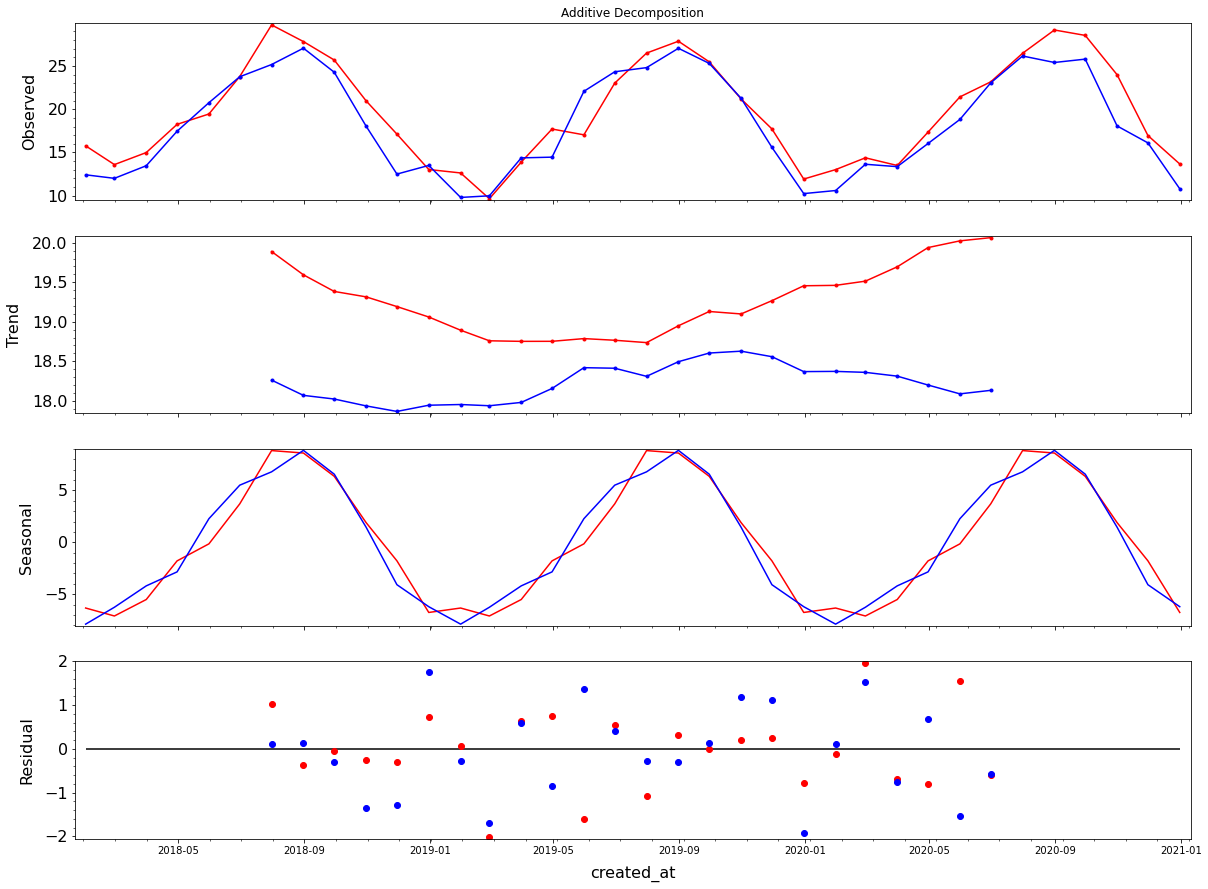

In [25]:
fig, ax = plt.subplots(4, sharex=True, figsize=(20, 15))
ax[0].set_title("Additive Decomposition")

ax[0].plot(decomp_a.observed.index, decomp_a.observed, ".-", color="red")
ax[0].plot(decomp_a.observed.index, decomp_b.observed, ".-", color="blue")
ax[0].minorticks_on()
ax[0].set(ylabel="Observed")

ax[1].plot(decomp_a.trend.index, decomp_a.trend, ".-", color="red")
ax[1].plot(decomp_a.trend.index, decomp_b.trend, ".-", color="blue")
ax[1].minorticks_on()
ax[1].set(ylabel="Trend")

ax[2].plot(decomp_a.seasonal.index, decomp_a.seasonal, color="red")
ax[2].plot(decomp_a.seasonal.index, decomp_b.seasonal, color="blue")
ax[2].minorticks_on()
ax[2].set(ylabel="Seasonal")

ax[3].plot(decomp_a.resid.index, decomp_a.resid, "o", color="red")
ax[3].plot(decomp_a.resid.index, decomp_b.resid, "o", color="blue")
ax[3].hlines(0, xmin=min(decomp_a.resid.index), xmax=max(decomp_a.resid.index), colors="black")
ax[3].minorticks_on()
ax[3].set(xlabel="created_at", ylabel="Residual")

plt.show()

In [28]:
zipcode_index = 0
params = {"zipcode": distinct_zipcodes[zipcode_index]}

select_nsr_rows = f"""
SELECT date_time, year, zipcode,
-- Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature, Relative_Humidity,
Wind_Speed, Precipitable_Water
from nsrdb
where zipcode = :zipcode;
"""

df_ = pd.read_sql(
    select_nsr_rows,
    conn,
    params=params,
    index_col="date_time",
    parse_dates=["date_time"],
)

df_.sort_index(axis=0, inplace=True)
df_.head(5)

,year,zipcode,Clearsky_DNI,DNI,Clearsky_GHI,GHI,Temperature,Relative_Humidity,Wind_Speed,Precipitable_Water
date_time,,,,,,,,,,
1998-01-01 00:30:00,1998,91708,0.0,0.0,0.0,0.0,13.0,65.10,1.0,1.548
1998-01-01 01:30:00,1998,91708,0.0,0.0,0.0,0.0,13.0,61.26,1.0,1.468
1998-01-01 02:30:00,1998,91708,0.0,0.0,0.0,0.0,13.0,58.23,1.0,1.405
1998-01-01 03:30:00,1998,91708,0.0,0.0,0.0,0.0,13.0,56.02,1.1,1.367
1998-01-01 04:30:00,1998,91708,0.0,0.0,0.0,0.0,13.0,53.99,1.1,1.361


In [32]:
df_rsm = df_.resample("M").mean().reset_index(drop=False)
df_rsm.set_index("date_time", inplace=True)
# df_rsm.head(24)

In [33]:
period = 12

feature_a = "Clearsky_DNI"
decomp_a = seasonal_decompose(df_rsm[feature_a], model="additive", period=period)

feature_b = "DNI"
decomp_b = seasonal_decompose(df_rsm[feature_b], model="additive", period=period)

feature_c = "Clearsky_GHI"
decomp_c = seasonal_decompose(df_rsm[feature_c], model="additive", period=period)

feature_d = "GHI"
decomp_d = seasonal_decompose(df_rsm[feature_d], model="additive", period=period)

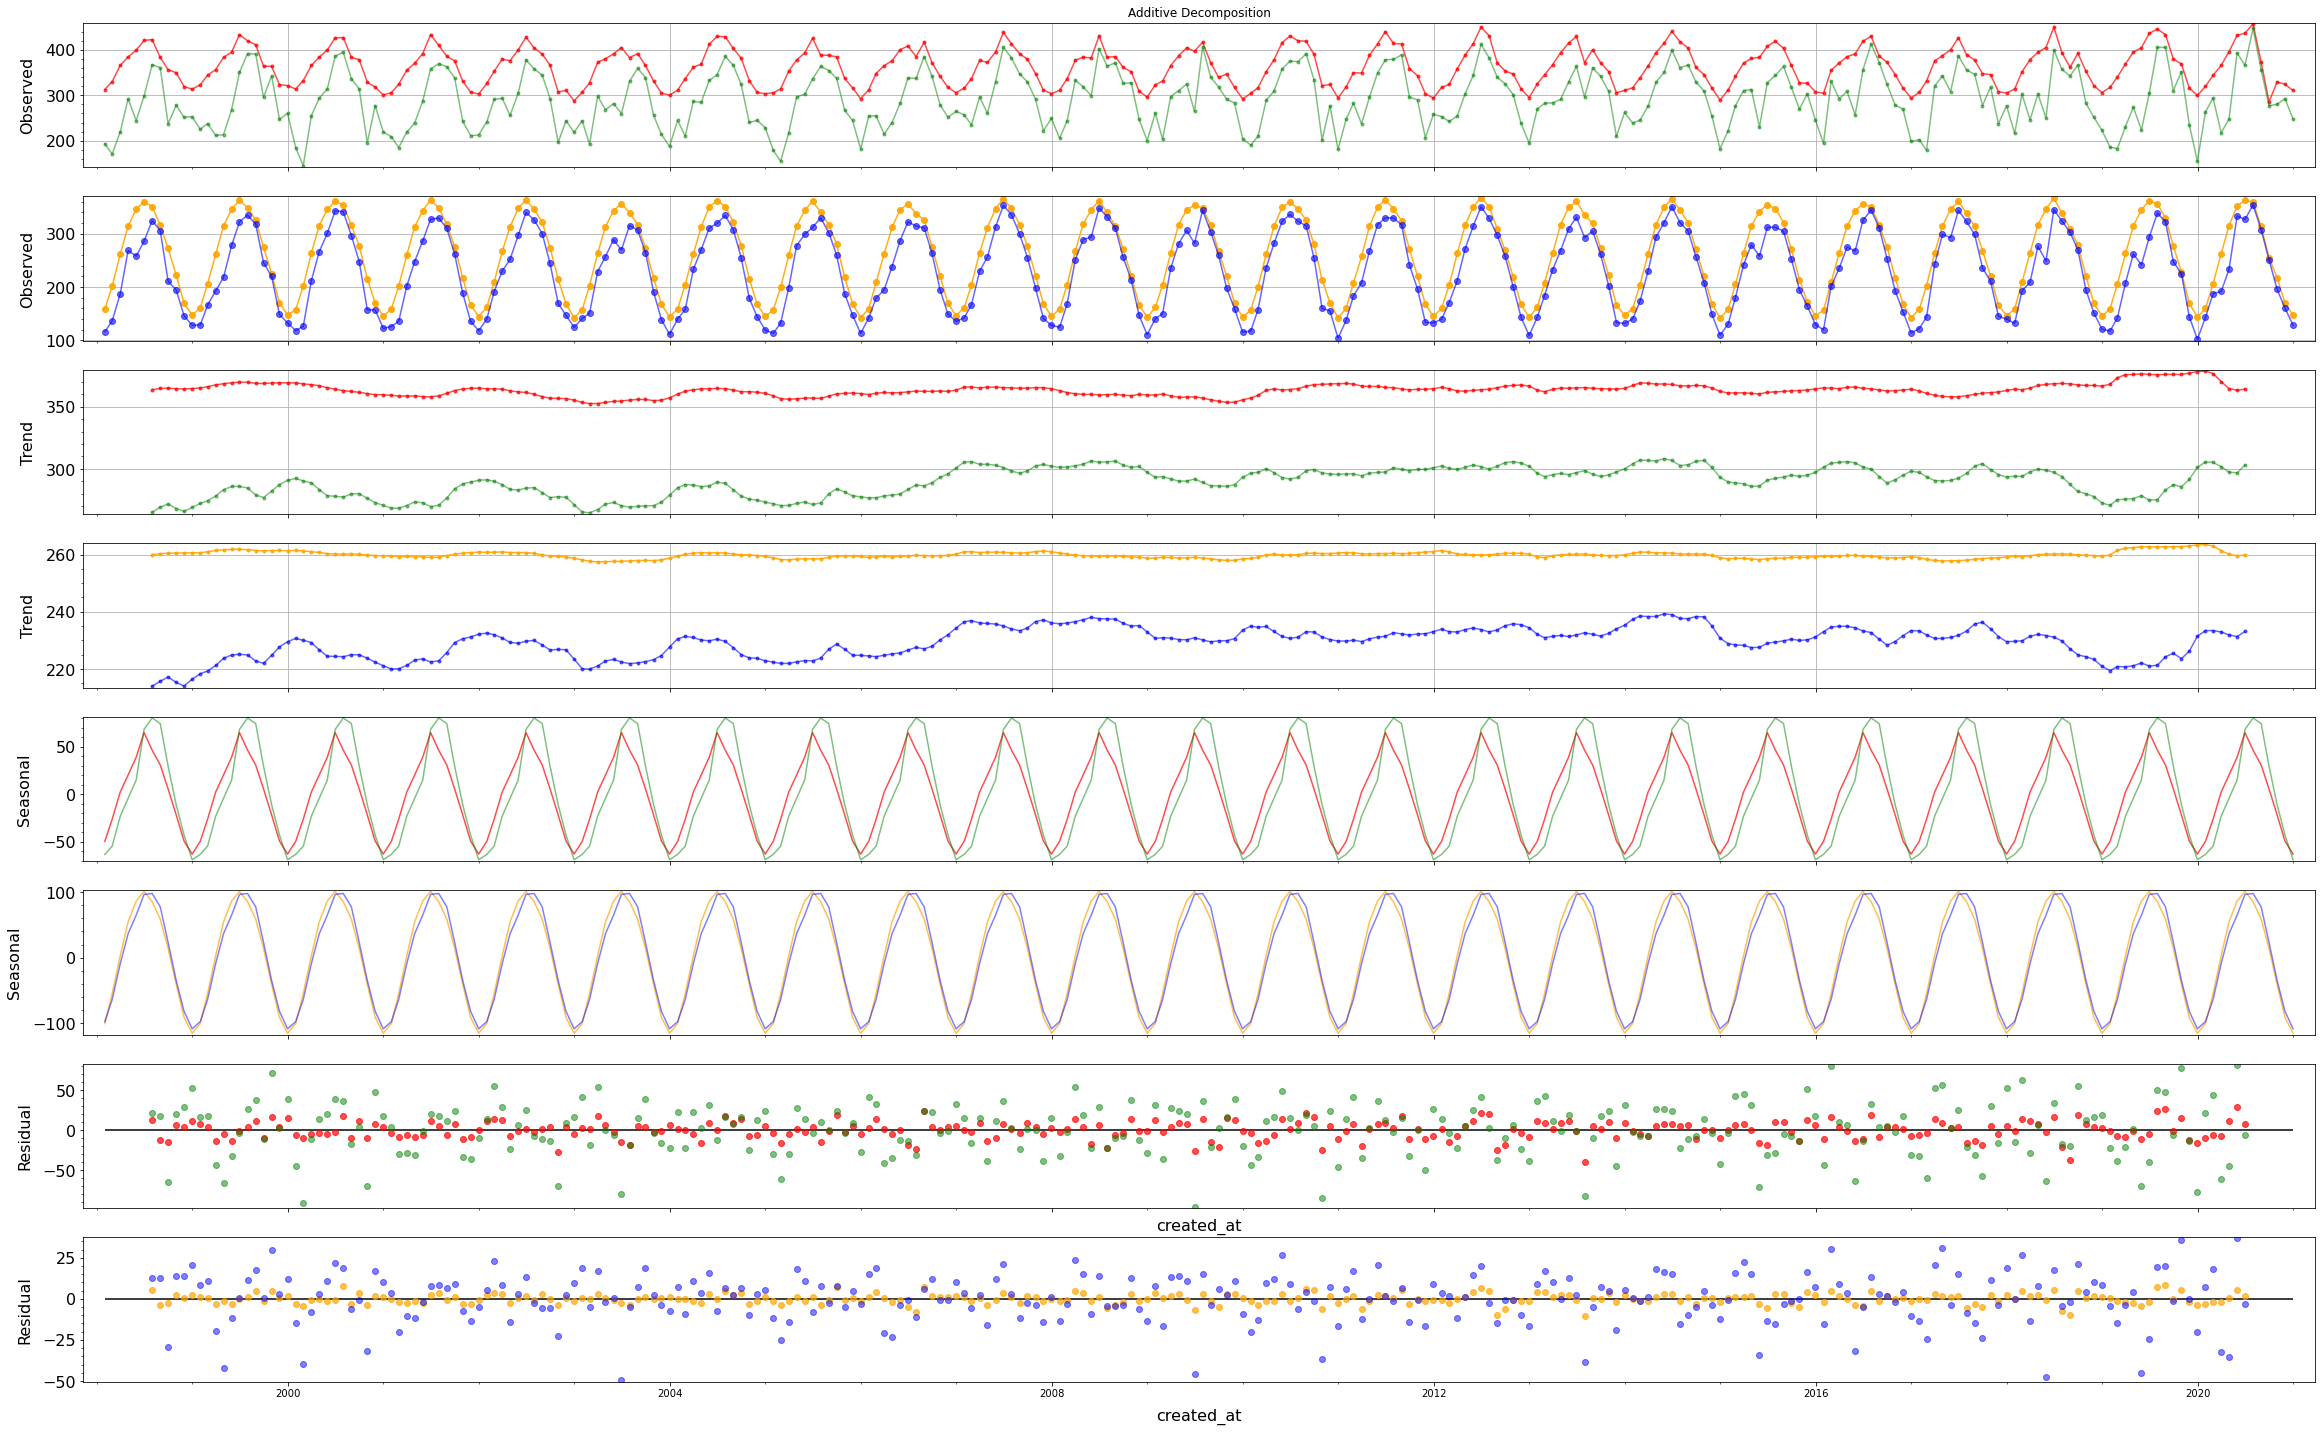

In [34]:
fig, ax = plt.subplots(8, sharex=True, figsize=(40, 25))
ax[0].set_title("Additive Decomposition")

ax[0].plot(decomp_a.observed.index, decomp_a.observed, ".-", color="red", alpha=0.7)
ax[0].plot(decomp_b.observed.index, decomp_b.observed, ".-", color="green", alpha=0.5)
ax[0].minorticks_on()
ax[0].grid()
ax[0].set(ylabel="Observed")

ax[1].plot(decomp_c.observed.index, decomp_c.observed, "o-", color="orange", alpha=0.9)
ax[1].plot(decomp_d.observed.index, decomp_d.observed, "o-", color="blue", alpha=0.6)
ax[1].minorticks_on()
ax[1].grid()
ax[1].set(ylabel="Observed")

ax[2].plot(decomp_a.trend.index, decomp_a.trend, ".-", color="red", alpha=0.7)
ax[2].plot(decomp_b.trend.index, decomp_b.trend, ".-", color="green", alpha=0.5)
ax[2].minorticks_on()
ax[2].grid()
ax[2].set(ylabel="Trend")

ax[3].plot(decomp_c.trend.index, decomp_c.trend, ".-", color="orange", alpha=0.9)
ax[3].plot(decomp_d.trend.index, decomp_d.trend, ".-", color="blue", alpha=0.6)
ax[3].minorticks_on()
ax[3].grid()
ax[3].set(ylabel="Trend")


ax[4].plot(decomp_a.seasonal.index, decomp_a.seasonal, color="red", alpha=0.7)
ax[4].plot(decomp_b.seasonal.index, decomp_b.seasonal, color="green", alpha=0.5)
ax[4].minorticks_on()
ax[4].set(ylabel="Seasonal")

ax[5].plot(decomp_c.seasonal.index, decomp_c.seasonal, color="orange", alpha=0.7)
ax[5].plot(decomp_d.seasonal.index, decomp_d.seasonal, color="blue", alpha=0.5)
ax[5].minorticks_on()
ax[5].set(ylabel="Seasonal")


ax[6].plot(decomp_a.resid.index, decomp_a.resid, "o", color="red", alpha=0.7)
ax[6].plot(decomp_b.resid.index, decomp_b.resid, "o", color="green", alpha=0.5)
ax[6].hlines(0, xmin=min(decomp_a.resid.index), xmax=max(decomp_a.resid.index), colors="black")
ax[6].minorticks_on()
ax[6].set(xlabel="created_at", ylabel="Residual")

ax[7].plot(decomp_c.resid.index, decomp_c.resid, "o", color="orange", alpha=0.7)
ax[7].plot(decomp_d.resid.index, decomp_d.resid, "o", color="blue", alpha=0.5)
ax[7].hlines(0, xmin=min(decomp_a.resid.index), xmax=max(decomp_a.resid.index), colors="black")
ax[7].minorticks_on()
ax[7].set(xlabel="created_at", ylabel="Residual")

plt.show()

In [35]:
neg = decomp_b.resid[decomp_b.resid < 0].sum()
pos = decomp_b.resid[decomp_b.resid > 0].sum()
print(f"neg: {neg}, pos: {pos}")

neg: -3460.1354083840038, pos: 3499.916146696086


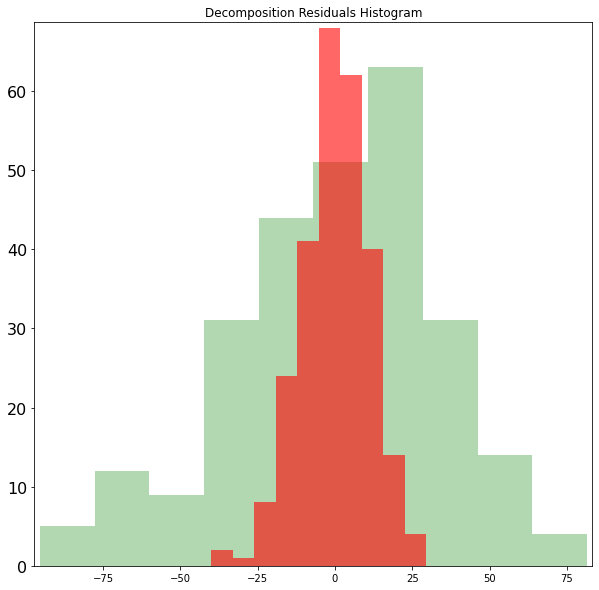

In [36]:
fig, ax = plt.subplots(1, sharex=True, figsize=(10, 10))
ax.set_title("Decomposition Residuals Histogram")

ax.hist(decomp_b.resid, color="green", alpha=0.3)
ax.hist(decomp_a.resid, color="red", alpha=0.6)

plt.show()

In [37]:
neg = decomp_d.resid[decomp_d.resid < 0].sum()
pos = decomp_d.resid[decomp_d.resid > 0].sum()
print(f"neg: {neg}, pos: {pos}")

neg: -1528.9310795702825, pos: 1546.4382744031686


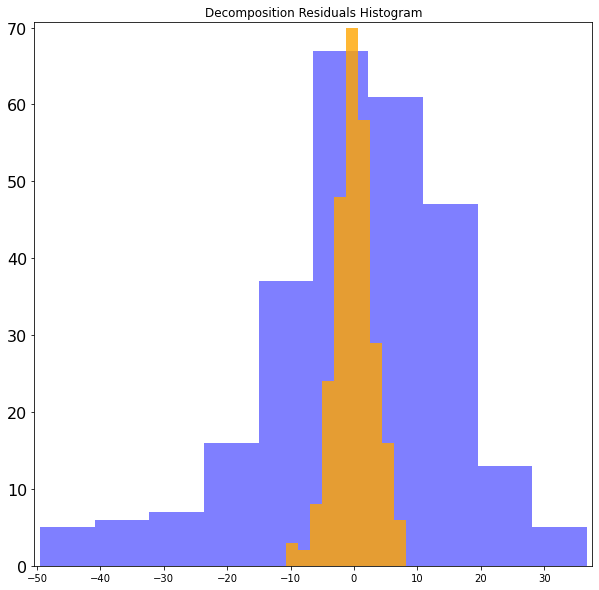

In [38]:
fig, ax = plt.subplots(1, sharex=True, figsize=(10, 10))
ax.set_title("Decomposition Residuals Histogram")

ax.hist(decomp_d.resid, color="blue", alpha=0.5)
ax.hist(decomp_c.resid, color="orange", alpha=0.8)

plt.show()

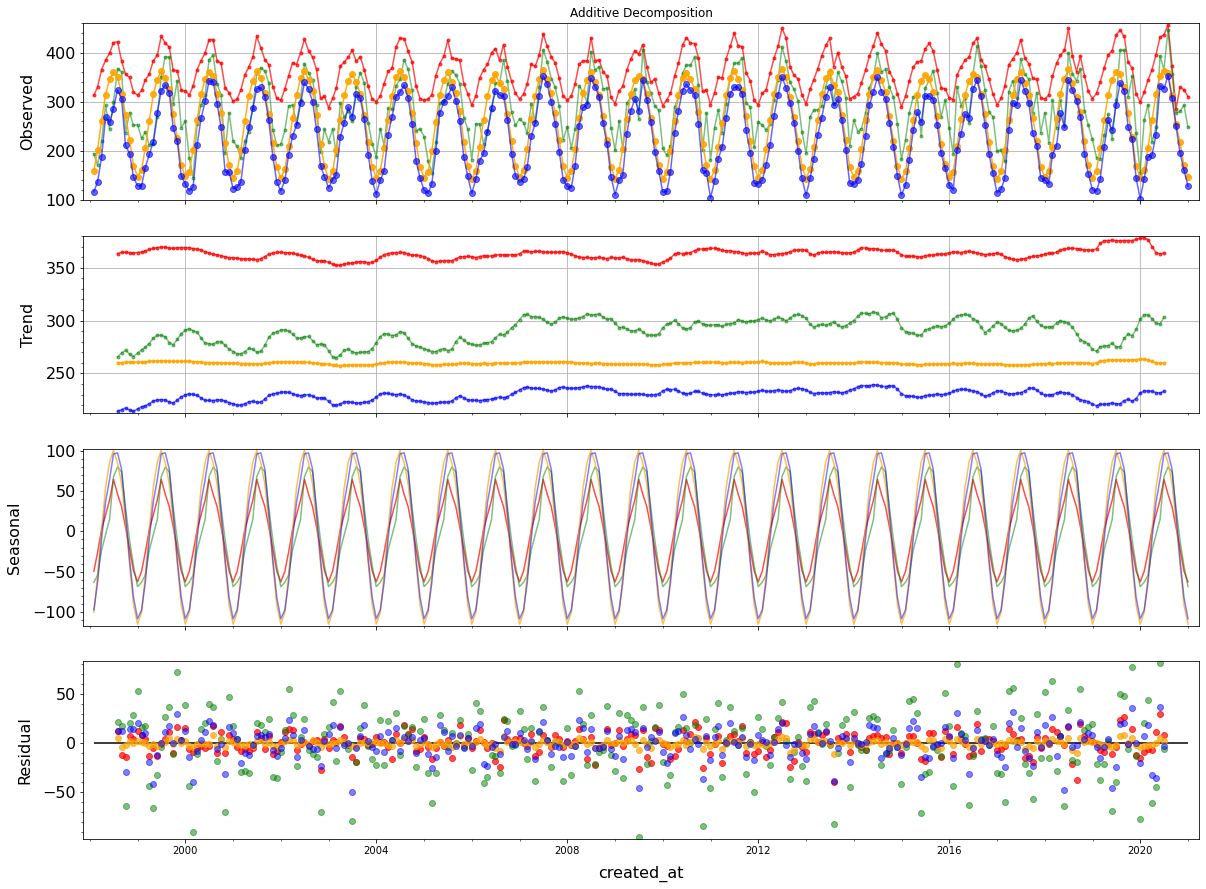

In [39]:
fig, ax = plt.subplots(4, sharex=True, figsize=(20, 15))
ax[0].set_title("Additive Decomposition")

ax[0].plot(decomp_a.observed.index, decomp_a.observed, ".-", color="red", alpha=0.7)
ax[0].plot(decomp_b.observed.index, decomp_b.observed, ".-", color="green", alpha=0.5)
ax[0].plot(decomp_c.observed.index, decomp_c.observed, "o-", color="orange", alpha=0.9)
ax[0].plot(decomp_d.observed.index, decomp_d.observed, "o-", color="blue", alpha=0.6)
ax[0].minorticks_on()
ax[0].grid()
ax[0].set(ylabel="Observed")

ax[1].plot(decomp_a.trend.index, decomp_a.trend, ".-", color="red", alpha=0.7)
ax[1].plot(decomp_b.trend.index, decomp_b.trend, ".-", color="green", alpha=0.5)
ax[1].plot(decomp_c.trend.index, decomp_c.trend, ".-", color="orange", alpha=0.9)
ax[1].plot(decomp_d.trend.index, decomp_d.trend, ".-", color="blue", alpha=0.6)
ax[1].minorticks_on()
ax[1].grid()
ax[1].set(ylabel="Trend")

ax[2].plot(decomp_a.seasonal.index, decomp_a.seasonal, color="red", alpha=0.7)
ax[2].plot(decomp_b.seasonal.index, decomp_b.seasonal, color="green", alpha=0.5)
ax[2].plot(decomp_c.seasonal.index, decomp_c.seasonal, color="orange", alpha=0.7)
ax[2].plot(decomp_d.seasonal.index, decomp_d.seasonal, color="blue", alpha=0.5)
ax[2].minorticks_on()
ax[2].set(ylabel="Seasonal")


ax[3].plot(decomp_a.resid.index, decomp_a.resid, "o", color="red", alpha=0.7)
ax[3].plot(decomp_b.resid.index, decomp_b.resid, "o", color="green", alpha=0.5)
ax[3].plot(decomp_c.resid.index, decomp_c.resid, "o", color="orange", alpha=0.7)
ax[3].plot(decomp_d.resid.index, decomp_d.resid, "o", color="blue", alpha=0.5)
ax[3].hlines(0, xmin=min(decomp_a.resid.index), xmax=max(decomp_a.resid.index), colors="black")
ax[3].minorticks_on()
ax[3].set(xlabel="created_at", ylabel="Residual")

plt.show()

In [23]:
period = 12

feature_e = "Temperature"
decomp_e = seasonal_decompose(df_[feature_e], model="additive", period=period)

feature_f = "Relative_Humidity"
decomp_f = seasonal_decompose(df_[feature_f], model="additive", period=period)

feature_g = "Wind_Speed"
decomp_g = seasonal_decompose(df_[feature_g], model="additive", period=period)

feature_h = "Precipitable_Water"
decomp_h = seasonal_decompose(df_[feature_d], model="additive", period=period)

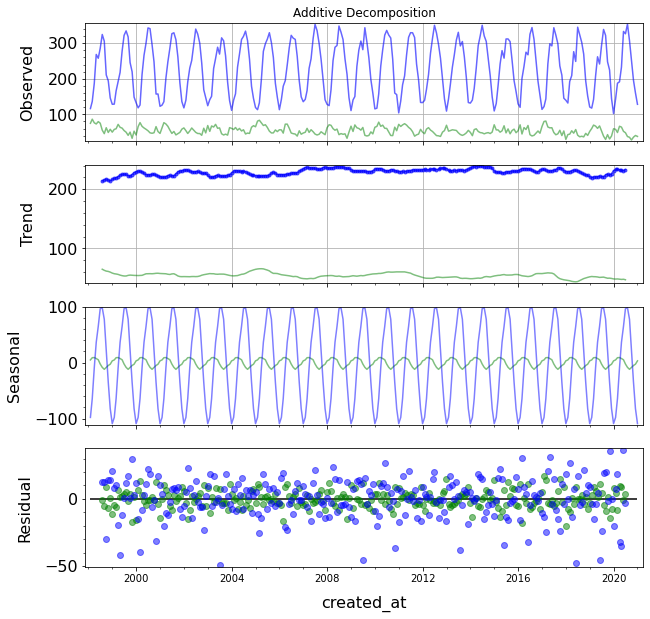

In [24]:
fig, ax = plt.subplots(4, sharex=True)
ax[0].set_title("Additive Decomposition")

# ax[0].plot(decomp_e.observed.index, decomp_e.observed, '-', color='red', alpha=.7)
ax[0].plot(decomp_f.observed.index, decomp_f.observed, "-", color="green", alpha=0.5)
# ax[0].plot(decomp_g.observed.index, decomp_g.observed, '-', color='orange', alpha=.9)
ax[0].plot(decomp_h.observed.index, decomp_h.observed, "-", color="blue", alpha=0.6)
ax[0].minorticks_on()
ax[0].grid()
ax[0].set(ylabel="Observed")

# ax[1].plot(decomp_e.trend.index, decomp_e.trend, '-', color='red', alpha=.7)
ax[1].plot(decomp_f.trend.index, decomp_f.trend, "-", color="green", alpha=0.5)
# ax[1].plot(decomp_g.trend.index, decomp_g.trend, '.-', color='orange', alpha=.9)
ax[1].plot(decomp_h.trend.index, decomp_h.trend, ".-", color="blue", alpha=0.6)
ax[1].minorticks_on()
ax[1].grid()
ax[1].set(ylabel="Trend")

# ax[2].plot(decomp_e.seasonal.index, decomp_e.seasonal, '-', color='red', alpha=.7)
ax[2].plot(decomp_f.seasonal.index, decomp_f.seasonal, "-", color="green", alpha=0.5)
# ax[2].plot(decomp_g.seasonal.index, decomp_g.seasonal, '-', color='orange', alpha=.7)
ax[2].plot(decomp_h.seasonal.index, decomp_h.seasonal, "-", color="blue", alpha=0.5)
ax[2].minorticks_on()
ax[2].set(ylabel="Seasonal")


# ax[3].plot(decomp_e.resid.index, decomp_e.resid, "o", color='red', alpha=.7)
ax[3].plot(decomp_f.resid.index, decomp_f.resid, "o", color="green", alpha=0.5)
# ax[3].plot(decomp_g.resid.index, decomp_g.resid, "o", color='orange', alpha=.7)
ax[3].plot(decomp_h.resid.index, decomp_h.resid, "o", color="blue", alpha=0.5)
ax[3].hlines(0, xmin=min(decomp_a.resid.index), xmax=max(decomp_a.resid.index), colors="black")
ax[3].minorticks_on()
ax[3].set(xlabel="created_at", ylabel="Residual")

plt.show()